In [86]:
# ---------------------------------------------------------------------------------------
# NATURAL LANGUAGE PROCESSING - RESEARCH_NOTE
# Hertie School - Fall 2024
# Instructor: Sascha Göbel
# Submitted by: Gayatri Shejwal (233352)
# ---------------------------------------------------------------------------------------


# PREPARATIONS ==========================================================================

# load libraries ------------------------------------------------------------------------
import pandas as pd
import numpy as np
from datasets import load_dataset
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import gensim
from gensim import corpora
from gensim.models import LdaModel
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from datetime import datetime, timezone


In [108]:
# Import datasets -----------------------------------------------------------------------
ds_linkedin = load_dataset("xanderios/linkedin-job-postings", split="train")
#ds_linkedin = pd.read_csv('postings.csv')
ds_linkedin = ds_linkedin.to_pandas() #.iloc[0:10000, :]

ds_linkedin.head()

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,scraped
0,3757940104,553718.0,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,NaN,5250.00,NaN,MONTHLY,Full-time,"Little River, SC",...,NaN,Entry level,None,1.699090e+12,careers-demant.icims.com,0,FULL_TIME,USD,BASE_SALARY,1699138101
1,3757940025,2192142.0,Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...,NaN,NaN,NaN,None,Full-time,"Beaver Dam, WI",...,NaN,None,None,1.699080e+12,www.click2apply.net,0,FULL_TIME,None,None,1699085420
2,3757938019,474443.0,"Manager, Engineering",\nThe TSUBAKI name is synonymous with excellen...,NaN,NaN,NaN,None,Full-time,"Bessemer, AL",...,NaN,None,Bachelor's Degree in Mechanical Engineering pr...,1.699080e+12,www.click2apply.net,0,FULL_TIME,None,None,1699085644
3,3757938018,18213359.0,Cook,descriptionTitle\n\n Looking for a great oppor...,NaN,22.27,NaN,HOURLY,Full-time,"Aliso Viejo, CA",...,NaN,Entry level,None,1.699080e+12,jobs.apploi.com,0,FULL_TIME,USD,BASE_SALARY,1699087461
4,3757937095,437225.0,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",275834.0,NaN,205956.0,YEARLY,Full-time,United States,...,NaN,Mid-Senior level,None,1.699090e+12,careers.iherb.com,0,FULL_TIME,USD,BASE_SALARY,1699085346


In [97]:
ds_linkedin.shape

(33246, 5)

In [88]:
ds_linkedin['skills_desc'] = ds_linkedin['skills_desc'].fillna('No skills mentioned')
ds_linkedin["job_desc"] = ds_linkedin["description"] + " " + ds_linkedin["skills_desc"]
ds_linkedin = ds_linkedin[['location', 'title', 'job_desc']]
ds_linkedin.head()

,location,title,job_desc
0,"Little River, SC",Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...
1,"Beaver Dam, WI",Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...
2,"Bessemer, AL","Manager, Engineering",\nThe TSUBAKI name is synonymous with excellen...
3,"Aliso Viejo, CA",Cook,descriptionTitle\n\n Looking for a great oppor...
4,United States,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ..."


In [89]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_with_nltk(text):
    # Ensure the text is a string before processing
    if not isinstance(text, str):
        return ''  # Return an empty string for non-string input
    
    # Remove standalone hyphens and punctuation except hyphens in hyphenated words
    text = re.sub(r'(?<=\s)-|-(?=\s)', '', text)  # Remove standalone hyphens surrounded by spaces
    text = re.sub(r'[^\w\s-]', '', text)  # Remove punctuation except hyphens
    text = re.sub(r'\b\d+\b', '', text)  # Remove standalone numbers

    # Tokenize
    words = word_tokenize(text.lower())

    # Lemmatize and remove stopwords
    processed_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and (word.isalnum() or '-' in word)]

    return ' '.join(processed_words)

# Example usage
sample_text = "Looking for a data-driven engineer with experience in real-time systems."
cleaned_text = preprocess_with_nltk(sample_text)
print(cleaned_text)


looking data-driven engineer experience real-time system


In [90]:
ds_linkedin['cleaned_job_desc'] = ds_linkedin['job_desc'].apply(preprocess_with_nltk)


In [91]:
## Delete more stop words
other_stop_words = ["junior", "senior", "experience", "etc", "job", "work", "company", "technique",
                    "candidate", "skill", "skills", "language", "menu", "inc", "new", "plus", "years",
                    "technology", "organization", "ceo", "cto", "account", "manager", "mobile",
                    "developer", "product", "revenue", "strong", "excellence", "customer", "employee",
                    "team", "project", "year", "part", "full", "time", "opportunity", "ability", "including",
                    "account", "accounts", "action", "actions", "admin", "administrator", "applicant",
                    "applicants", "apply", "application", "applying", "assistant", "associate", "associate",
                    "candidate", "candidates", "career", "careers", "change", "changes", "company", "companies",
                    "consultant", "consulting", "contact", "contacts", "customer", "customers", "data", "date",
                    "details", "department", "departments", "employee", "employees", "employer", "employers",
                    "experience", "experiences", "field", "fields", "finance", "financial", "focus", "goal",
                    "goals", "hire", "hired", "hiring", "implement", "implementation", "job", "jobs", "level",
                    "levels", "manager", "management", "manager's", "organization", "organizations", "opportunity",
                    "opportunities", "position", "positions", "project", "projects", "promote", "promotion",
                    "recruiter", "recruiting", "role", "roles", "salary", "service", "services", "system",
                    "systems", "team", "teamwork", "title", "titles", "training", "training", "work", "works",
                    "required", "required skills", "skills", "knowledge", "required qualifications", "qualifications",
                    "experience", "expertise", "proficient", "proficiency", "needed", "must", "minimum", "maximum",
                    "certifications", "degrees", "education", "experience in", "required for", "available",
                    "available immediately", "details", "responsibilities", "expectations", "applicants", "attractive",
                    "benefits", "bonus", "challenge", "compensation", "candidates", "culture", "deadline", "detail-oriented",
                    "flexibility", "growing", "implement", "industry-leading", "innovative", "looking for", "pay", "perform",
                    "perform well", "position requires", "qualifications", "role-specific", "successful", "team-oriented",
                    "under pressure", "work environment", "client"]



In [92]:
ds_linkedin['cleaned_job_desc'] = ds_linkedin['cleaned_job_desc'].apply(lambda x: " ".join(x for x in x.split() if x not in other_stop_words))

In [93]:

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))

# Fit and transform the cleaned AI-related job descriptions
#X_tfidf = tfidf_vectorizer.fit_transform(py_jobs['cleaned_job_desc'])
X_tfidf = tfidf_vectorizer.fit_transform(ds_linkedin['cleaned_job_desc'])

In [94]:


# Convert the cleaned job descriptions into a list of words
#py_jobs['cleaned_job_desc_tokens'] = py_jobs['cleaned_job_desc'].apply(lambda x: x.split())
ds_linkedin['cleaned_job_desc_tokens'] = ds_linkedin['cleaned_job_desc'].apply(lambda x: x.split())

# Create a dictionary from the tokenized descriptions
dictionary = corpora.Dictionary(ds_linkedin['cleaned_job_desc_tokens'])

# Create a corpus from the dictionary
corpus = [dictionary.doc2bow(text) for text in ds_linkedin['cleaned_job_desc_tokens']]


In [ ]:

# Train the LDA model
lda_model = LdaModel(corpus, id2word=dictionary, num_topics=5,   # Number of topics
                     alpha=0.01,  
                     eta=0.01,       # Equivalent to beta
                     random_state=42,
                     passes=10)

# Display the topics
topics = lda_model.print_topics(num_words=10)  # Show top 10 words for each topic
for topic in topics:
    print(topic)


(0, '0.015*"design" + 0.012*"technical" + 0.012*"engineering" + 0.011*"development" + 0.010*"solution" + 0.009*"support" + 0.008*"software" + 0.008*"business" + 0.008*"process" + 0.007*"security"')
(1, '0.014*"business" + 0.008*"sale" + 0.007*"communication" + 0.006*"process" + 0.006*"support" + 0.006*"marketing" + 0.006*"development" + 0.005*"strategy" + 0.005*"relationship" + 0.005*"mentioned"')
(2, '0.010*"benefit" + 0.008*"u" + 0.007*"disability" + 0.007*"status" + 0.006*"sale" + 0.006*"people" + 0.006*"employment" + 0.006*"life" + 0.005*"gender" + 0.005*"paid"')
(3, '0.008*"duty" + 0.008*"equipment" + 0.008*"safety" + 0.007*"may" + 0.005*"andor" + 0.005*"requirement" + 0.005*"procedure" + 0.005*"information" + 0.005*"responsibility" + 0.005*"maintenance"')
(4, '0.023*"care" + 0.023*"patient" + 0.017*"health" + 0.013*"medical" + 0.010*"healthcare" + 0.009*"clinical" + 0.008*"program" + 0.007*"hospital" + 0.006*"family" + 0.006*"student"')


In [96]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.models import LdaModel

vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.enable_notebook() 
pyLDAvis.display(vis)
pyLDAvis.save_html(vis, 'lda_visualization.html')



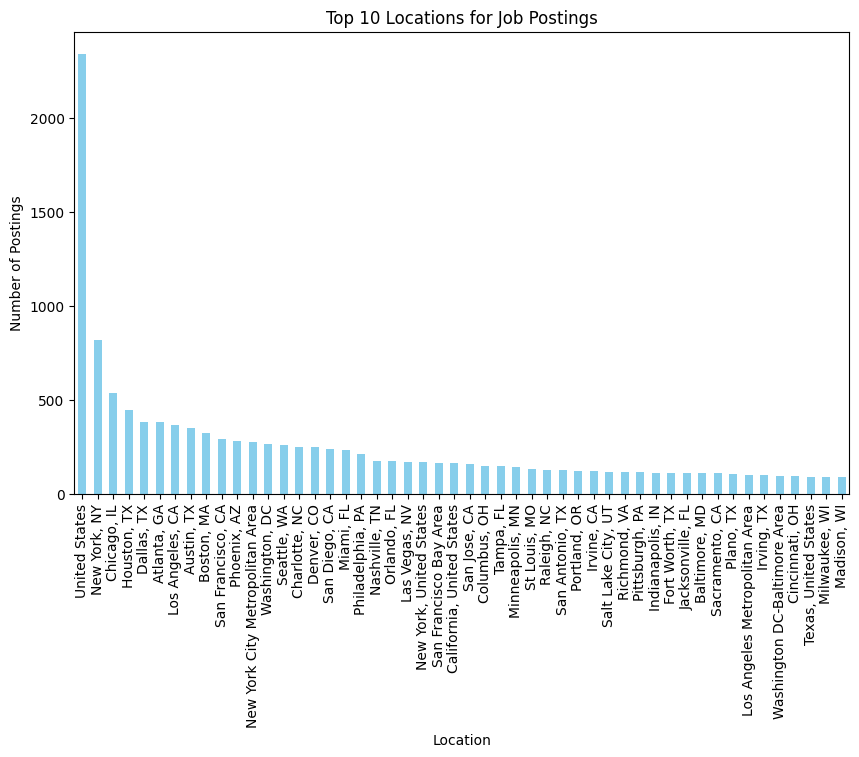

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

# Bar chart for geographic distribution
geo_counts = ds_linkedin['location'].value_counts()
geo_counts.head(50).plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Top 10 Locations for Job Postings')
plt.xlabel('Location')
plt.ylabel('Number of Postings')
plt.show()




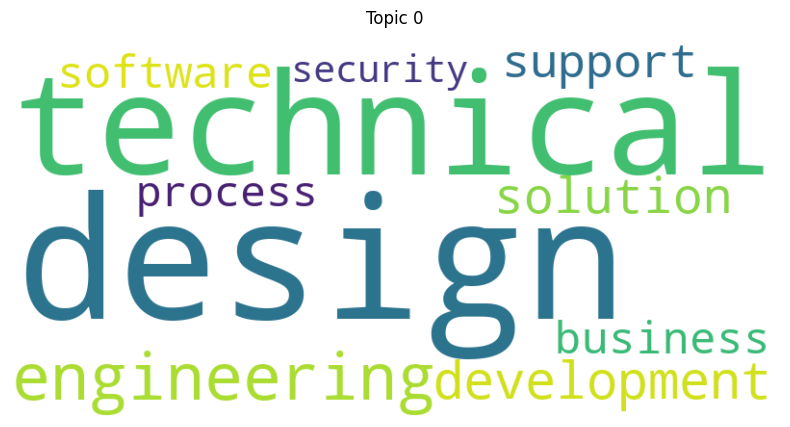

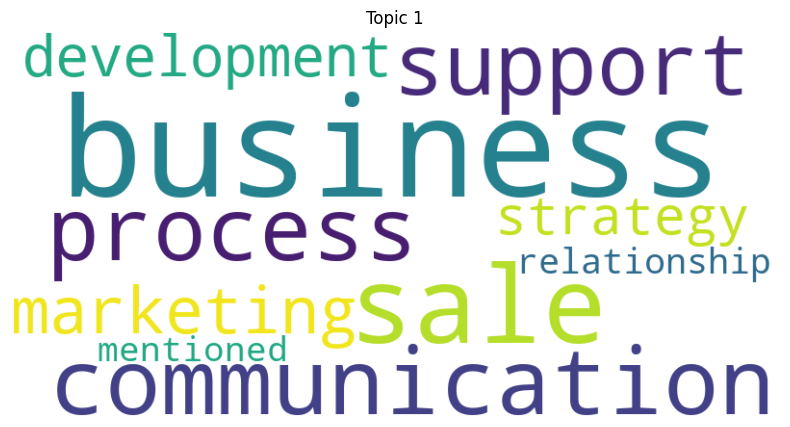

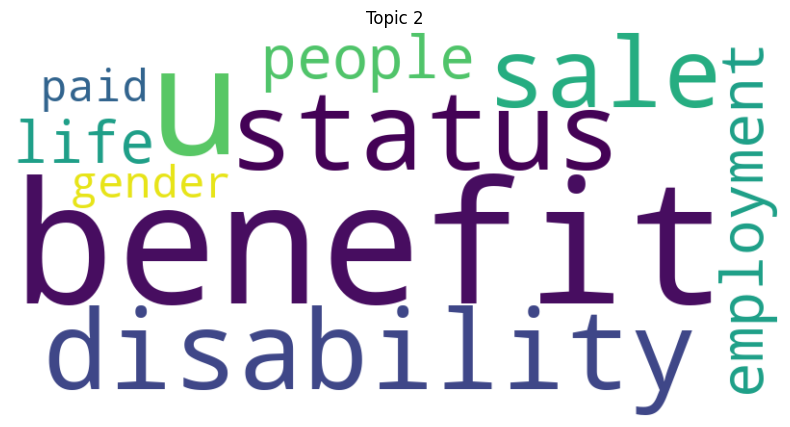

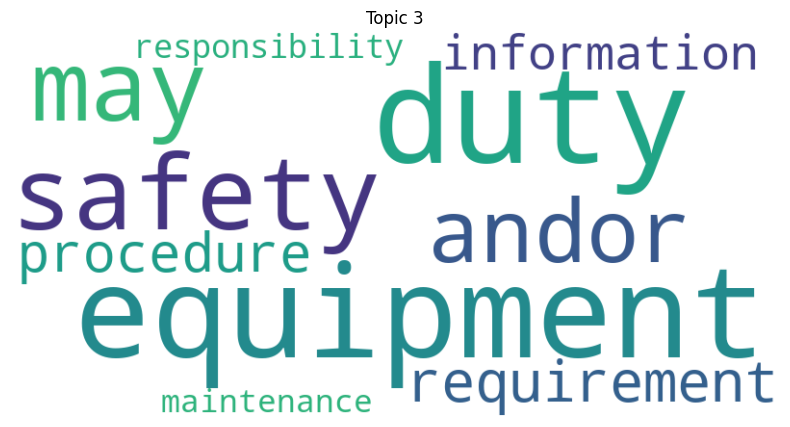

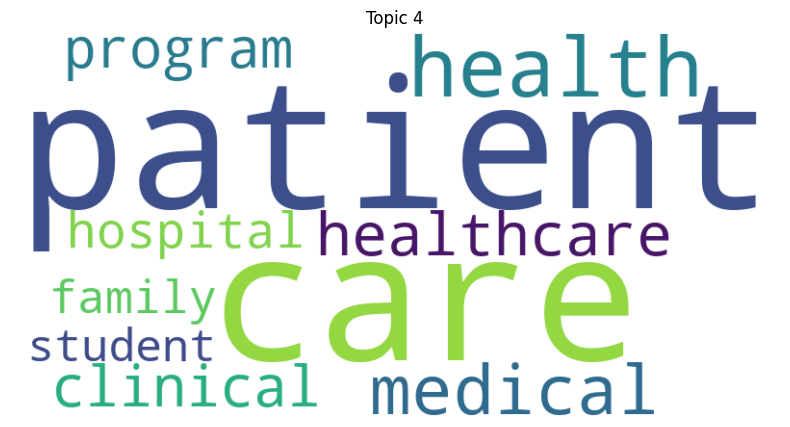

In [118]:

# Generate a word cloud for each topic
for i, topic in lda_model.show_topics(formatted=False, num_words=10):
    topic_words = dict(topic)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_words)
    
    # Create a new figure for each word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {i}")
    
    # Save each word cloud to a separate file
    plt.savefig(f'wordcloud_topic_{i}.png', bbox_inches='tight', dpi=300)
    plt.show()  # Display the word cloud




In [113]:

# Convert 'listed_time' from milliseconds to seconds
ds_linkedin['listed_time'] = ds_linkedin['listed_time'] / 1000

# Find the earliest and latest timestamps
earliest_listed_timestamp = ds_linkedin['listed_time'].min()
latest_listed_timestamp = ds_linkedin['listed_time'].max()

# Convert timestamps to datetime objects with UTC timezone
earliest_listed_date = datetime.fromtimestamp(earliest_listed_timestamp, tz=timezone.utc)
latest_listed_date = datetime.fromtimestamp(latest_listed_timestamp, tz=timezone.utc)

# Print the results
print(f"Earliest listed date: {earliest_listed_date}")
print(f"Latest listed date: {latest_listed_date}")


Earliest listed date: 2023-08-10 12:20:00+00:00
Latest listed date: 2023-11-04 23:20:00+00:00
